In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from multiprocessing.dummy import Pool as ThreadPool

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [85]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model
    

    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','auroc'])
    groupres = {} #results on each group for each model
    
    auroc_all = []
    tpr_all = []
    fpr_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
#         #Round predicted scores for Regression to nearest whole number
#         if (model_name == 'Random Forest Regressor'):
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        yscore = clf.predict_proba(Xte)
        if len(np.unique(yte))>1:
            yte_bin = label_binarize(yte, clf.classes_)
            for c in list(range(yte_bin.shape[1]))[::-1]:
                if not any(yte_bin[:,c]):
                    yte_bin = np.delete(yte_bin,[c],axis=1)
                    yscore = np.delete(yscore,[c],axis=1)
                
            auroc = roc_auc_score(yte_bin,yscore,average='weighted')
            fpr_mean = np.array(range(0,101))/100
            tprs = []
            for i in range(yte_bin.shape[1]):
                yt = yte_bin[:,i]
                ys = yscore[:,i]
                fpr, tpr, thresh = roc_curve(yt,ys)
                tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                tprs.append(tpr)
                
            tpr = sum(tprs)
            fpr = fpr_mean
        else:
            #print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
            fpr = np.array([])
            tpr = np.array([])

        tpr_all.append(tpr)
        fpr_all.append(fpr)
        auroc_all.append(auroc)
        
        r = pd.DataFrame({'model':model_name, 'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
    
    groupres[model_name] = {'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all}
    
    return results, groupres

In [47]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
datadict = {'watch':{},'sensor':{}, 'accel':{}}
for freq in [50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['watch'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['sensor'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['accel'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)

In [ ]:
#Skip this cell and open pkl file

t1=time.time()
results = {}
MultiResults = {}

for mode in ['watch','sensor','accel']:

    results[mode] = {}
    MultiResults[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        count = 0
        print(mode + ', ' + symptom)
        results[mode][symptom] = {}

        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = {}

        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()
        MultiResults[mode][symptom] = {}

        for freq in datadict[mode].keys():

            count += 1
            print('Frequency %d of %d'%(count,len(datadict[mode].keys())))
            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            if (mode == 'sensor') and (symptom == 'Tremor'):
                Data = Data.iloc[:,:49]
            
            X = Data.iloc[:,5:].values
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.values

            #Binary

            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups[freq] = res_group

            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['auroc'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['auroc'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])
            MultiResults[mode][symptom][freq] = res_group
            
            #Regressor

#             y = Data[symptom].values.astype(int) #target 

#             model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
#             model_name = ['Random Forest Regressor']
#             model = list(zip(model,model_name))

#             res,res_group = LOSOMultiClass(Data,X,y,groups,model)
#             res['Sampling Rate'] = str(freq) + ' Hz'
#             regress_res_groups = pd.concat((regress_res_groups,res))
#             R = pd.DataFrame()
#             R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
#             R['Model'] = ['Random Forest'] 
#             R['Sampling Rate'] = [str(freq) + ' Hz']
#             regress_res_all = pd.concat([regress_res_all,R])

        results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[mode][symptom]['Binary']['res_groups'] = binary_res_groups
        
        results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups
        
#         results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
#         results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
        
f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\DownsampleAnalysisResults','wb')
pickle.dump(results,f)
f.close()

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

watch, Tremor
Frequency 1 of 8
Training Random Forest


In [90]:
results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\DownsampleAnalysisResults','wb')
pickle.dump(results,f)
f.close()

In [120]:
#Open results as pickle file

f = open('Y:\\CIS-PD Study\\DownsampleAnalysisResults','rb')
results = pickle.load(f)
f.close()

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


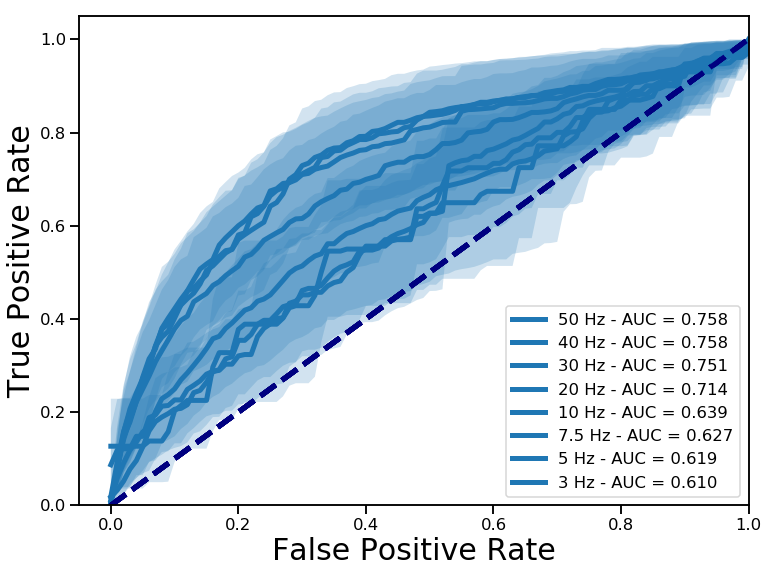

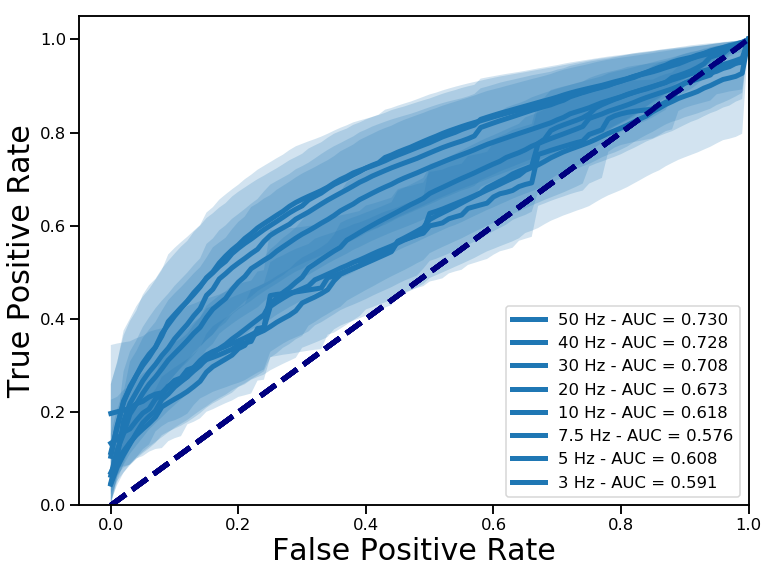

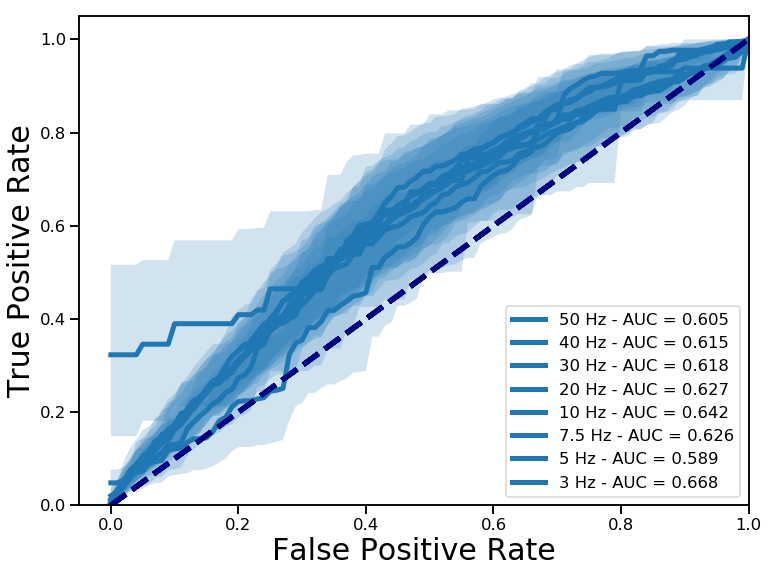

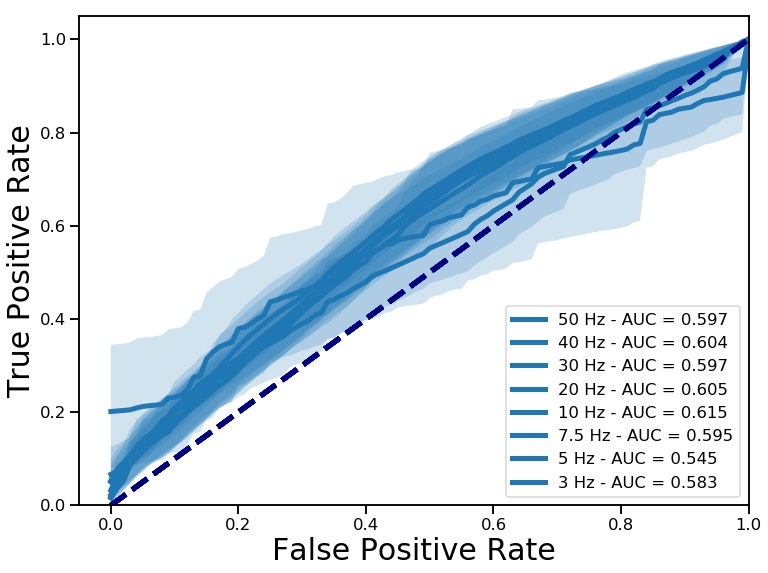

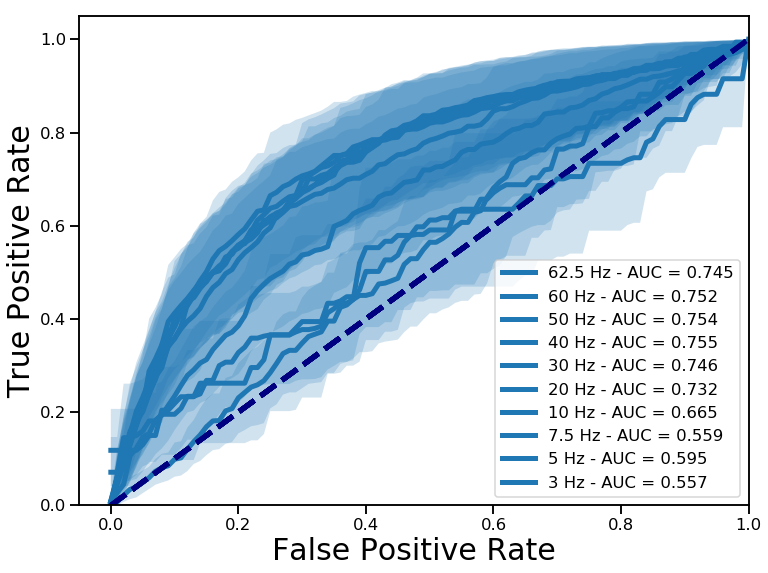

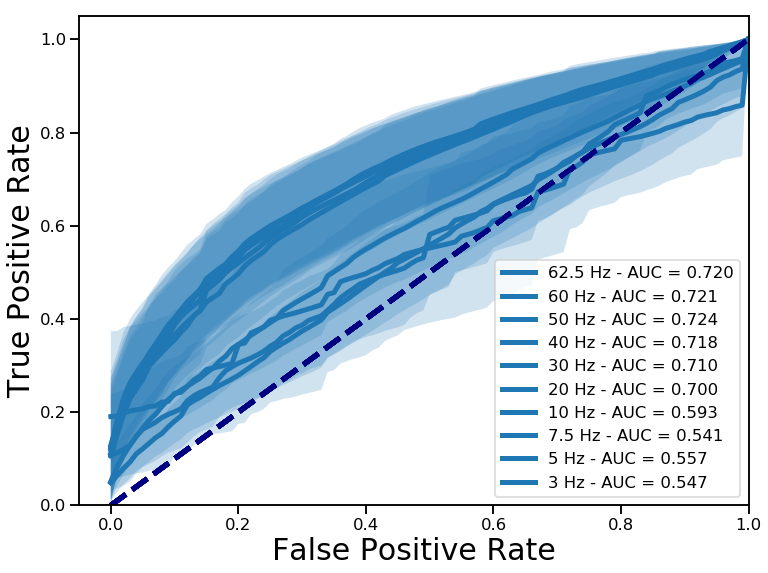

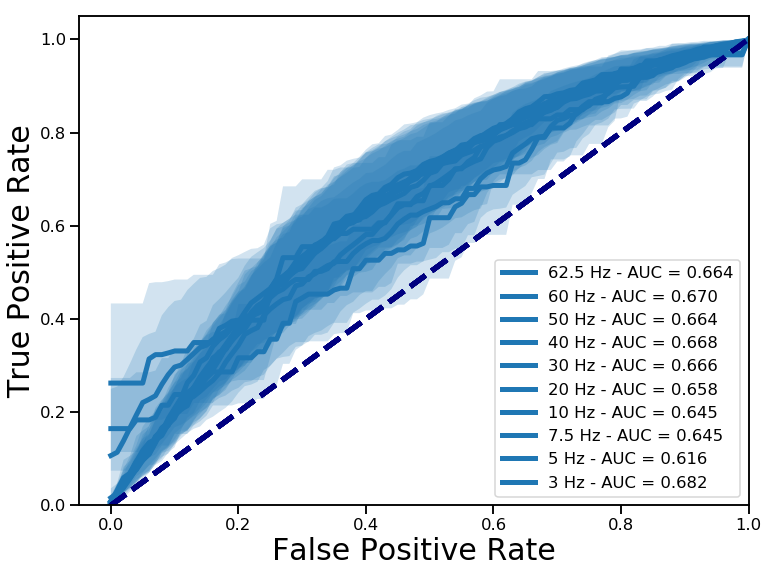

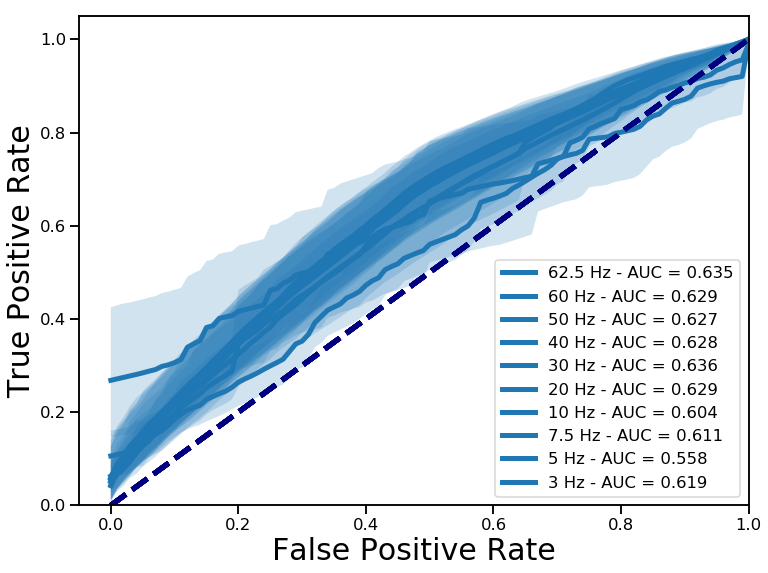

In [96]:
lw = 5
ls='-'

for mode in ['watch','sensor']:

    for symptom in ['Tremor','Bradykinesia']:

        firstPlot=True
        plt.figure(figsize=(12,9))

        for freq in datadict[mode].keys():
            
            data = results[mode][symptom]['Binary']['res_groups'][freq]['Random Forest']

            if firstPlot:
                ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                              plotname=str(freq)+' Hz',ls=ls, lw=lw)
            else:
                plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                         plotname=str(freq)+' Hz',ax = ax, col = c, ls = ls, lw=lw)
                
        ax.set_xlabel(ax.get_xlabel(), fontsize=30)
        ax.set_ylabel(ax.get_ylabel(), fontsize=30)

        firstPlot=True
        plt.figure(figsize=(12,9))
        
        for freq in datadict[mode].keys():
            
            data = MultiResults[mode][symptom][freq]['Random Forest']
            
            if firstPlot:
                ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                              plotname=str(freq)+' Hz',ls=ls, lw=lw)
            else:
                plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                         plotname=str(freq)+' Hz',ax = ax, col = c, ls = ls, lw=lw)
                
        ax.set_xlabel(ax.get_xlabel(), fontsize=30)
        ax.set_ylabel(ax.get_ylabel(), fontsize=30)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


KeyError: 40

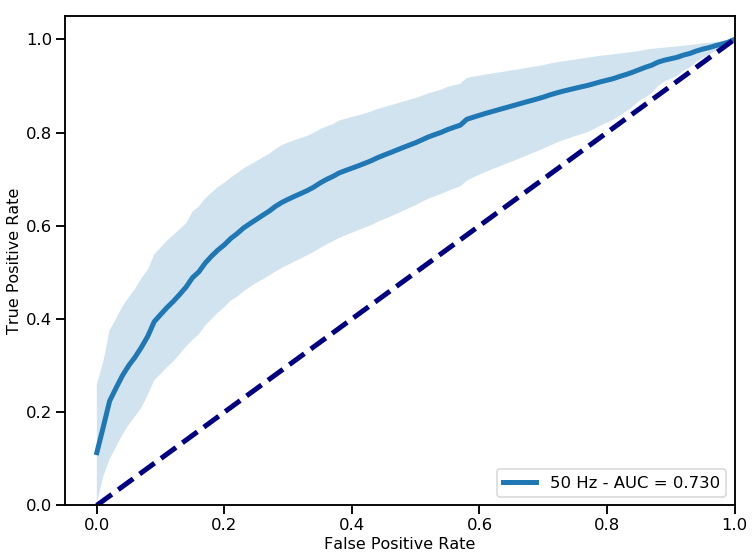

In [94]:
firstPlot=True
plt.figure(figsize=(12,9))

for freq in datadict[mode].keys():

    data = MultiResults[mode][symptom][freq]['Random Forest']

    if firstPlot:
        ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                      plotname=str(freq)+' Hz',ls=ls, lw=lw)
    else:
        plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                 plotname=str(freq)+' Hz',ax = ax, col = c, ls = ls, lw=lw)

In [33]:
def barplotFreq(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = results[mode][symptom][classifier]['res_all']['Sampling Rate'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
    else:
        groups = results[mode][symptom][classifier]['res_groups']['Sampling Rate']
        RMS = results[mode][symptom][classifier]['res_groups']['auroc']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('AUROC')
        m = results[mode][symptom][classifier]['res_all']['auroc'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,1])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.title('%s Model Performance v. %s Frequency: %s'%(classifier,mode,symptom))
    
    plt.savefig('Results/Resample_%s_%s_%s.png'%(mode,symptom,classifier),format='png',dpi=1000)

In [34]:
def stats_tests(mode,symptom,classifier):
    #sort data into organized dataframe
    df = pd.DataFrame()
    freqlist = list(results[mode][symptom][classifier]['res_all']['Sampling Rate'])
    if classifier == 'Binary':
        for i in range(len(freqlist)):
            freq = freqlist[i]
            df[freq] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['50 Hz'].isnull()].reset_index(drop=True)
    else:
        for freq in freqlist:
            df[freq] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Sampling Rate']==freq]['auroc']
        df = df.reset_index(drop=True)
    
    #rmANOVA tests
    print('Repeated Measures ANOVA')
    cols = [freqlist[0]]
    for freq in freqlist[1:]:
        cols = cols + [freq]
        p = rmANOVA(df,cols)
        print(', '.join(cols))
        print('p-value: ' + str(p))
        print()
        
    #paired t tests    
    d = results[mode][symptom][classifier]['res_all']
    if classifier == 'Binary':
        f = d[d.auroc == max(d.auroc)]['Sampling Rate'].values[0]
        print('Maximum AUROC: %s'%f)
        print()
    else:
        f = d[d.auroc == max(d.auroc)]['Sampling Rate'].values[0]
        print('Maximum AUROC: %s'%f)
        print()
    for freq in freqlist:
        if freq == f:
            continue
        print('%s, %s'%(f,freq))
        print(stats.ttest_rel(df[f],df[freq]))

In [35]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return stats.f.sf(F,dfbw,dferror)

In [43]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.9247676574011142

50 Hz, 40 Hz, 30 Hz
p-value: 0.10692024471084761

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.10990498265370742

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.0010420243897582573

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.499193980179569e-06

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 2.8088914341978395e-07

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 1.0983989059911627e-06

Maximum AUROC: 50 Hz

50 Hz, 40 Hz
Ttest_relResult(statistic=0.0968389212422399, pvalue=0.924767657401112)
50 Hz, 30 Hz
Ttest_relResult(statistic=1.7955453038260831, pvalue=0.10279523070932553)
50 Hz, 20 Hz
Ttest_relResult(statistic=1.4596206985744264, pvalue=0.17508295447007075)
50 Hz, 10 Hz
Ttest_relResult(statistic=2.5034206120450277, pvalue=0.03126308280579084)
50 Hz, 7.5 Hz
Ttest_relResult(statistic=4.795068409524141, pvalue=0.0007290149174159193)
50 Hz, 5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
50 Hz, 

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


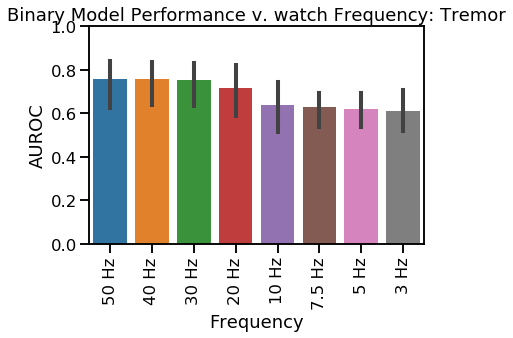

In [8]:
barplotFreq('watch','Tremor','Binary')
stats_tests('watch','Tremor','Binary')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.002412593591556447

50 Hz, 40 Hz, 30 Hz
p-value: 3.308916293724928e-16

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 7.38002503406109e-10

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 1.6506244858991778e-27

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.184477772472637e-38

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 4.3142582378241163e-44

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 3.430803892709112e-45

Maximum AUROC: 50 Hz

50 Hz, 40 Hz
Ttest_relResult(statistic=3.9152168914794387, pvalue=0.0024125935915402658)
50 Hz, 30 Hz
Ttest_relResult(statistic=16.226915208395546, pvalue=4.968144017365644e-09)
50 Hz, 20 Hz
Ttest_relResult(statistic=5.896847669922167, pvalue=0.00010358995076898768)
50 Hz, 10 Hz
Ttest_relResult(statistic=23.837949575577834, pvalue=8.068836811438863e-11)
50 Hz, 7.5 Hz
Ttest_relResult(statistic=23.037107817080123, pvalue=1.1670808508118196e-10)
50 Hz, 5 Hz
Ttest_relResult(statistic=21.6336

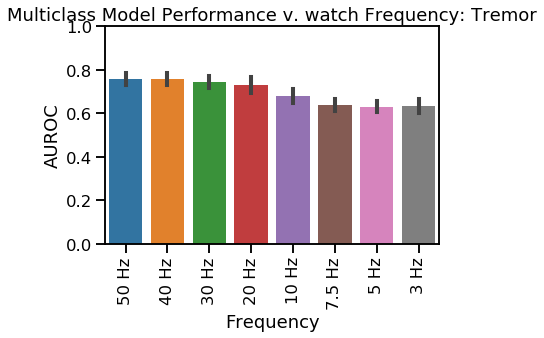

In [36]:
barplotFreq('watch','Tremor','Multiclass')
stats_tests('watch','Tremor','Multiclass')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.12395217547276298

50 Hz, 40 Hz, 30 Hz
p-value: 0.06442326741420444

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.04952154634148603

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.028517383719912175

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.1953483966683487

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.38931024076739873

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.2501306062572625

Maximum AUROC: 3 Hz

3 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 40 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 30 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 20 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 10 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 7.5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


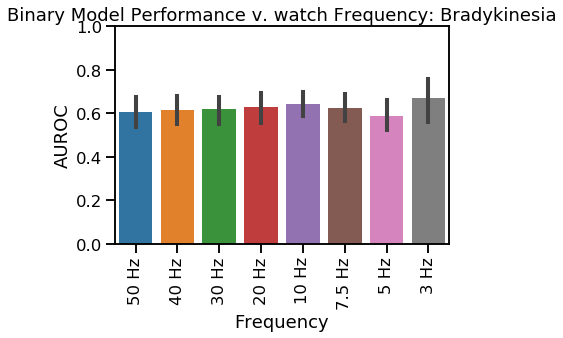

In [37]:
barplotFreq('watch','Bradykinesia','Binary')
stats_tests('watch','Bradykinesia','Binary')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.0009087538489185139

50 Hz, 40 Hz, 30 Hz
p-value: 0.0020617771613268008

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.01697286221030063

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.00401187836205403

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.05866386565173557

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 1.1830895688722739e-08

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 3.2679416914300967e-07

Maximum AUROC: 10 Hz

10 Hz, 50 Hz
Ttest_relResult(statistic=3.287637792341316, pvalue=0.0072349996975476704)
10 Hz, 40 Hz
Ttest_relResult(statistic=1.6050472278213983, pvalue=0.1367857526569272)
10 Hz, 30 Hz
Ttest_relResult(statistic=2.196702374653034, pvalue=0.05037538093202782)
10 Hz, 20 Hz
Ttest_relResult(statistic=1.7776743298940434, pvalue=0.10307895598765089)
10 Hz, 7.5 Hz
Ttest_relResult(statistic=5.358181250789192, pvalue=0.00023090933752353148)
10 Hz, 5 Hz
Ttest_relResult(statistic=8.2925099734509, pval

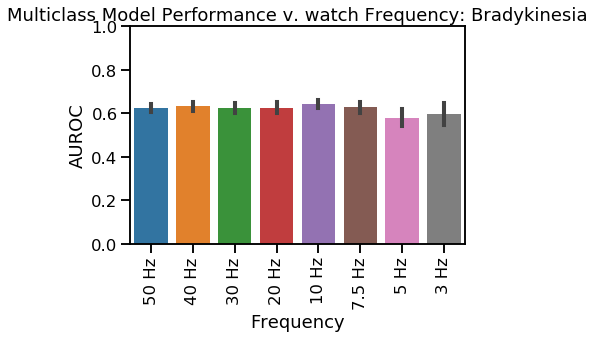

In [38]:
barplotFreq('watch','Bradykinesia','Multiclass')
stats_tests('watch','Bradykinesia','Multiclass')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.007827376842616335

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.18849919574820112

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.3197575505642747

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.5522942127795561

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.04523196179008014

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 6.022844208333385e-14

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 8.395045665713843e-18

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 3.371026885337091e-24

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 5.12193059234983e-15

Maximum AUROC: 40 Hz

40 Hz, 62.5 Hz
Ttest_relResult(statistic=1.350128823293323, pvalue=0.20673919547488567)
40 Hz, 60 Hz
Ttest_relResult(statistic=0.34992692845754103, pvalue=0.7336514326870405)
40 Hz, 50 Hz
Ttest_relResult(statistic=0.5721995545311576, pvalue=0.579821932810012)
40 Hz, 30 Hz
Ttest_relResult(st

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


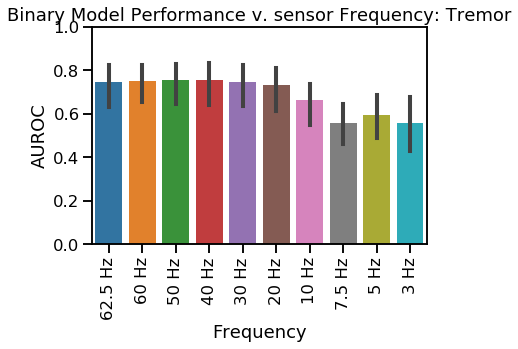

In [39]:
barplotFreq('sensor','Tremor','Binary')
stats_tests('sensor','Tremor','Binary')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.01610170079935148

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.000144702641928324

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 9.713954665333661e-06

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 7.155808299807187e-09

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 4.554661365275391e-18

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 3.8208461673512467e-47

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 1.639783213835194e-53

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 6.2091686013900775e-52

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 4.476521079280527e-33

Maximum AUROC: 50 Hz

50 Hz, 62.5 Hz
Ttest_relResult(statistic=3.8030526178112103, pvalue=0.0029277645868846405)
50 Hz, 60 Hz
Ttest_relResult(statistic=3.7433863817050415, pvalue=0.0032470166513375136)
50 Hz, 40 Hz
Ttest_relResult(statistic=3.6880379758853885, pvalue=0.0035753627037072738)
50 Hz, 30 H

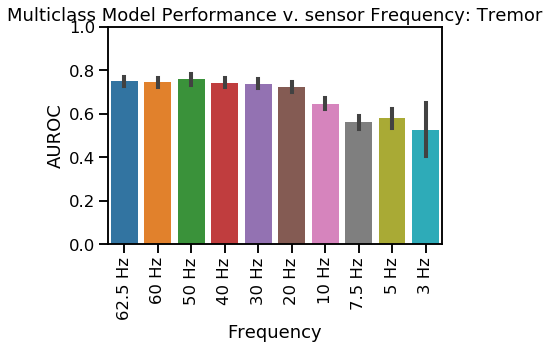

In [40]:
barplotFreq('sensor','Tremor','Multiclass')
stats_tests('sensor','Tremor','Multiclass')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.3331106359962581

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.6538848452624352

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.8061204401089056

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.9212850896607915

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.7424189426913445

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.40434775214684454

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.7682250104496846

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.32294120390074454

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.5789718612710187

Maximum AUROC: 3 Hz

3 Hz, 62.5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 60 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 40 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 30 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 20 Hz
Ttest_relResult(

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


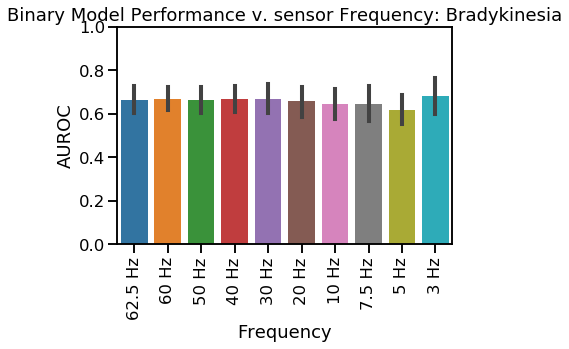

In [41]:
barplotFreq('sensor','Bradykinesia','Binary')
stats_tests('sensor','Bradykinesia','Binary')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.0014121350775747948

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.0016450682116917912

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.0007920124380920538

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 1.3318965146697019e-07

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 3.313931087763377e-07

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 1.7315181980497324e-20

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.006907012681223e-19

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 2.639137403545302e-39

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 2.609978597475186e-26

Maximum AUROC: 20 Hz

20 Hz, 62.5 Hz
Ttest_relResult(statistic=1.6499389876204793, pvalue=0.12718938686395626)
20 Hz, 60 Hz
Ttest_relResult(statistic=4.080717724667931, pvalue=0.001817982849019493)
20 Hz, 50 Hz
Ttest_relResult(statistic=4.148080896395525, pvalue=0.0016217098195078438)
20 Hz, 40 Hz


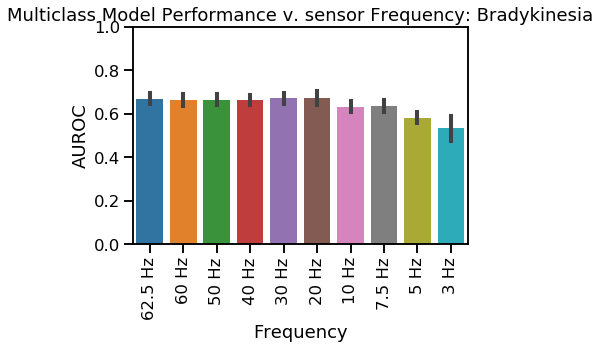

In [42]:
barplotFreq('sensor','Bradykinesia','Multiclass')
stats_tests('sensor','Bradykinesia','Multiclass')